In [1]:
import numpy as np
import parallelization as pl
import h5py
import sys
import os
from math import ceil

In [2]:
class HaloChain():

    ### Initialization function
    def __init__(self, halo_id, params, mainhalo_progenitors=None, extra_cores=0):
        '''
        Initializes HaloChain object with given params and calculates starting values

        Parameters:
            halo_id:                catalog ID of halo to be tracked
            params:                 (sim, z0, startsnap, endsnap, path, finder, nmem, pcut)
            mainhalo_progenitors:   list of all progenitors for central host halo. Avoids mis-assigning for 
                                    satellite halos. None if halo_id is the host halo
            extra_cores:            default value of 0. If not 0, indicates how many other cores are available
                                    for speeding up calculations (particularly for host halos)
        Output:
            None
        '''

        # Expand input parameters
        sim, z0, startsnap, endsnap, path, finder, nmem, pcut = params

        # Open halo-star catalog and extract initial star IDs, weights, and halo properties
        with h5py.File(f'../data/HaloStarCatalogs/halostarcatalog_{sim}.hdf5', 'r') as catalog:

            decoder = np.vectorize(lambda x: x.decode('utf-8'))
            init_starids = decoder(catalog[str(startsnap)][str(halo_id)]['star.ids'][:])

            distances = catalog[str(startsnap)][halo_id]['star.distance'][:]
            halo_pos = catalog[str(startsnap)][halo_id]['halo.pos'][:]
            halo_rvir = catalog[str(startsnap)][halo_id]['halo.rvir'][()]
            halo_mvir = np.log10(catalog[str(startsnap)][halo_id]['halo.mvir'][()])
            halo_mstell50 = np.log10(np.sum(catalog[str(startsnap)][halo_id]['star.mass'][:][distances < 0.5*halo_rvir]))
            halo_mstell100 = np.log10(np.sum(catalog[str(startsnap)][halo_id]['star.mass'][:]))
            
            init_starids = init_starids[distances < 0.5*halo_rvir]
            init_starweights = 1 / distances[distances < 0.5*halo_rvir]**2
            init_starweights /= sum(init_starweights)

        # Assign attributes (non-looped variables)
        self.name = halo_id                                 # Halo catalog ID
        self.sim = sim                                      # Simulation
        self.z0 = z0                                        # Starting redshift
        self.path = path                                    # Path to snapshot data
        self.finder = finder                                # Halo finder used (either AHF or rockstar)
        self.nmem = nmem                                    # Number of snapshots included in star particle memory
        self.pcut = pcut                                    # Minimum number of particles necessary for halo to be considered
        self.startsnap = startsnap                          # Starting snapshot
        self.endsnap = endsnap                              # Ending snapshot
        self.extracores = extra_cores                       # Number of extra cores available for speeding up calculations
        self.state = 'CandidateHalos'                       # State of tracking: (CandidateHalos, NoHalos, NoStarParticles)
        self.mainhalo_progenitors = mainhalo_progenitors    # Progenitors of main halo in simulation -> should not be identified as progenitors of another descendant halo
        self.initstarids = init_starids                     # Star particles IDs at final snapshot -> anchor to these
        
        # Assign attributes (looped variables)
        # Flagging convention:  1: progenitor identified, 0: no progenitor identified, progenitor star particles present, -1: no progenitor halo or stars
        self.relaxation = -np.ones(startsnap - endsnap + 1)             # Flags to reflect how "relaxed" the progenitor identifiaction is
                                                                        #       0: within 1 dex virial mass of descendent, at least 75% of constituent star particles were already in memory
                                                                        #       1: within 2 dex virial mass of descendent, at least 75% of constituent star particles were already in memory
                                                                        #       2: within 2 dex virial mass of descendent, at least 50% of constituent star particles were already in memory
                                                                        #       3: star particles present, no good candidate halos
                                                                        #       4: no remaining star particles, algorithm terminated
        self.progenitor_id = -np.ones(startsnap - endsnap + 1)          # Array containing the catalog IDs of each of the progenitor halos
        self.rvir = -np.ones(startsnap - endsnap + 1)                   # Array of virial radii of progenitor halos
        self.mvir = -np.ones(startsnap - endsnap + 1)                   # Array of virial mass of progenitor halos
        self.mstell50 = -np.ones(startsnap - endsnap + 1)               # Array of stellar mass contained within the inner 50% of the virial radius
        self.mstell100 = -np.ones(startsnap - endsnap + 1)              # Array of stellar mass contained within the entire virial radius
        self.position = -np.ones((startsnap - endsnap + 1, 3))          # (x, y, z) position of progenitor in comoving kpc
        
        self.relaxation[0] = 0
        self.progenitor_id[0] = halo_id
        self.rvir[0] = halo_rvir
        self.mvir[0] = halo_mvir
        self.mstell50[0] = halo_mstell50
        self.mstell100[0] = halo_mstell100
        self.position[0, :] = halo_pos
        
        # Create dictionary of star particle weights to be updated each snapshot. Populate all nmem slots with the starting weight upon initialization
        init_dictionary = {}
        for (star, weight) in zip(init_starids, init_starweights):
            init_dictionary[star] = np.array([weight]*nmem)
        self.stardictionary = init_dictionary
        
        return
    
    ### Helper function to cycle weights in the star particle dictionary each snapshot. This works for a single star particle and is mapped across all
    def cycle_weights(self, weight_arr, weight):
        '''
        Cycles weights in star particle dictionary memory (used to update after each loop and progenitor identification)

        Parameters:
            weight_arr: array of weights for a single star particle
            weight:     new weight calculated this snapshot for that star particle
        Output:
            cycled weight array where the variable "weight" is at index 0 and the old values are cycled back one index
        '''

        weight_arr[1:] = weight_arr[:-1]
        weight_arr[0] = weight
        return weight_arr
    
    ### For a given halo, finds how many and what fraction of its star particles are stored in memory
    def match_starparticles(self, catalog, snap, halo, star_ids):
        '''
        For a given candidate progenitor, calculates how many of its constituent star particles are found in memory, 
        and what fraction of the total number of star particles are in memory

        Parameters:
            catalog:    catalog (opened hdf5) of halos and which star particles lie inside them
            halo:       halo ID whose chi score is to be calculated
            snap:       snapshot at which progenitor is being calculated
            star_ids:   star particle IDs for all star particles in memory with nonzero weights
        Output:
            array containing nmatched and fmatched
            nmatched:   number of star particles found in memory
            fmatched:   fraction of star particles found in memory
        '''

        decoder = np.vectorize(lambda x: x.decode('utf-8'))
        starids_thishalo = decoder(catalog[str(snap)][halo]['star.ids'][:])
        distances = catalog[str(snap)][halo]['star.distance'][:]
        rvir = catalog[str(snap)][halo]['halo.rvir'][()]
        starids_thishalo = starids_thishalo[distances <= 0.5*rvir]
        
        nstars = len(starids_thishalo)
        nmatched = sum(np.isin(starids_thishalo, star_ids))
        fmatched = nmatched / nstars
        return np.array([nmatched, fmatched])
    
    ### Function to get chi score of a single halo at a given snapshot
    def get_chi(self, catalog, snap, halo, star_ids):
        '''
        Given a candidate progenitor and an array of all star particle IDs found in memory, calculate the chi score of the candidate progenitor.

        Parameters:
            catalog:    catalog (opened hdf5) of halos and which star particles lie inside them
            halo:       halo ID whose chi score is to be calculated
            snap:       snapshot at which progenitor is being calculated
            star_ids:   star particle IDs for all star particles in memory with nonzero weights
        Output:
            float representing the chi score of the halo in question
        '''
        
        decoder = np.vectorize(lambda x: x.decode('utf-8'))
        if (len(star_ids) > 1e4) and (self.extracores > 0):
            starids_thishalo = pl.Split(decoder, catalog[str(snap)][halo]['star.ids'][:], self.extracores+1)
            in_thishalo = np.isin(star_ids, starids_thishalo)
            weights = pl.Map(lambda star: np.sum(self.stardictionary[star]), star_ids[in_thishalo], self.extracores+1)
        else:
            starids_thishalo = decoder(catalog[str(snap)][halo]['star.ids'][:])
            in_thishalo = np.isin(star_ids, starids_thishalo)
            weights = [np.sum(self.stardictionary[star]) for star in star_ids[in_thishalo]]
        return sum(weights)
    
    ### Identifies progenitor at previous snapshot and updates memory
    def step(self, snap):
        '''
        Main functionality of progenitor identification code. Searches for candidate progenitors at previous snapshot, finds the best one
        using an adaptive criteria for relaxation of match strictness if necessary, and updates system state

        Parameters:
            snap:       snapshot at which progenitor is to be identified
        Output:
            If self.state = 'CandidateHalos':   Catalog ID, (x, y, z) position in ckpc, virial radius, virial mass, inner 50% stellar mass, 100% stellar mass,
                                                and consitituent star particles and their weights for the identified progenitor halo
            If self.state = 'NoHalos':          Returns the IDs of the star particles with nonzero weights in the previous snapshot, and uniform, normalized weights
            If self.state = 'NoStarParticles:   Returns None
        '''

        idx = self.startsnap - snap

        ### Get star IDs of interest and their weights
        star_ids = np.array(list(self.stardictionary.keys()))
        if self.state == 'CandidateHalos':
            star_weights = np.array([sum(self.stardictionary[star]) for star in self.stardictionary.keys()])   # Take all memory slots into consideration
            in_mem = star_weights > 0.
        else:   # self.state = 'NoHalos'
            star_weights = np.array([self.stardictionary[star][0] for star in self.stardictionary.keys()])   # Get only IDs and weights from the snapshot previously looped over
            in_mem = star_weights > 0
            if sum(in_mem) < 5:
                self.state = 'NoStarParticles'
                self.relaxation[idx] = 4
                print('*** Insufficient number of star particles for tracking. Terminating program... ***')
                return
            else:
                pass

        ### Match star IDs in memory with star IDs present in each halo in the previous snapshot
        with h5py.File(f'../data/HaloStarCatalogs/halostarcatalog_{self.sim}.hdf5', 'r') as catalog:
            
            ## Read in halos and their virial masses from catalog
            halos_id = np.array(list(catalog[str(snap)].keys()))
            if self.mainhalo_progenitors is not None:
                halos_id = halos_id[halos_id != self.mainhalo_progenitors[idx]]   # Exclude host halo and its progenitors from consideration (for ease of calculation)
            else:
                pass
            halos_mvir = np.array([np.log10(catalog[str(snap)][ID]['halo.mvir'][()]) for ID in halos_id])
            halos_nmatched = np.zeros(len(halos_id))   # Will hold number of constituent star particles found in memory
            halos_fmatched = np.zeros(len(halos_id))   # Will hold fraction of constituent star particles found in memory

            ## Identify candidate progenitors in the standard case (descendant halo identified in the subsequent snapshot)
            if self.state == 'CandidateHalos':
                
                # Strictest check: within 1 dex and at least 75% of constituent star particles are found in the descendant halo -> create filter
                relaxation = 0
                mass_filt = np.abs(halos_mvir - self.mvir[idx-1]) < 1
                for halo in halos_id[mass_filt]:
                    distances_temp = catalog[str(snap)][halo]['star.distance'][:]
                    rvir_temp = catalog[str(snap)][halo]['halo.rvir'][()]
                    print(len(catalog[str(snap)][halo]['star.ids'][:]), 
                          len(catalog[str(snap)][halo]['star.ids'][:][distances_temp < 0.5*rvir_temp]))
                match_stats = np.array(list(map(lambda halo: self.match_starparticles(catalog, snap, halo, star_ids[in_mem]), halos_id[mass_filt])))
                halos_nmatched[mass_filt] = match_stats[:, 0]
                halos_fmatched[mass_filt] = match_stats[:, 1]
                print(halos_id[mass_filt])
                print(halos_nmatched[mass_filt])
                print(halos_fmatched[mass_filt])
                fraction_filt = (halos_fmatched >= 0.75) & (halos_nmatched >= self.pcut/2)

                # Only check the most massive 5 (or fewer depending on the number that pass the filter)
                if sum(fraction_filt) > 5:
                    halos_check = halos_id[np.argsort(halos_fmatched)[::-1][:5]]
                elif (sum(fraction_filt) > 0) and (sum(fraction_filt) <= 5):
                    halos_check = halos_id[fraction_filt]
                else:
                    # Relaxed mass: within 2 dex and at least 75% of constituent star particles are found in the descendant halo -> expand filter
                    print('*** Relaxing mass filter ***')
                    relaxation = 1
                    mass_filt_relaxed = (np.abs(halos_mvir - self.mvir[idx-1]) >= 1) & (np.abs(halos_mvir - self.mvir[idx-1]) < 2)
                    match_stats = np.array(list(map(lambda halo: self.match_starparticles(catalog, snap, halo, star_ids[in_mem]), halos_id[mass_filt_relaxed])))
                    halos_nmatched[mass_filt_relaxed] = match_stats[:, 0]
                    halos_fmatched[mass_filt_relaxed] = match_stats[:, 1]
                    fraction_filt = (halos_fmatched >= 0.75) & (halos_nmatched >= self.pcut/2)

                    if sum(fraction_filt) > 5:
                        halos_check = halos_id[np.argsort(halos_fmatched)[::-1][:5]]
                    elif (sum(fraction_filt) > 0) and (sum(fraction_filt) <= 5):
                        halos_check = halos_id[fraction_filt]
                    else:
                        # Relaxed mass and match fraction: within 2 dex and at least 50% of constituent star particles are found in the descendant halo
                        print('*** Relaxing fractional match filter ***')
                        relaxation = 2
                        fraction_filt = (halos_fmatched >= 0.5) & (halos_nmatched >= self.pcut/2)

                        if sum(fraction_filt) > 5:
                            halos_check = halos_id[np.argsort(halos_fmatched)[::-1][:5]]
                        elif (sum(fraction_filt) > 0) and (sum(fraction_filt) <= 5):
                            halos_check = halos_id[fraction_filt]
                        else:
                            # If no halos at all are found that meet our most relaxed criteria, we change the state of the progenitor tracking to only track
                            # star particles, provided that there are a sufficient number
                            relaxation = 3
                            self.state = 'NoHalos'

            ## Check for candidate progenitors in the special case (no descendant halo identified in the subsequent snapshot but more than pcut/2 star particles in memory present)
            else:   # self.state = 'NoHalos'

                match_stats = np.array(list(map(lambda halo: self.match_starparticles(catalog, snap, halo, star_ids[in_mem]), halos_id)))
                halos_nmatched[mass_filt] = match_stats[:, 0]
                halos_fmatched[mass_filt] = match_stats[:, 1]
                fraction_filt = (halos_fmatched >= 0.5) & (halos_nmatched >= self.pcut/2)

                if sum(fraction_filt) > 0:
                    relaxation = 2
                    self.state = 'CandidateHalos'
                    halos_check = halos_id[fraction_filt]
                else:
                    relaxation = 3

            ## Identify best progenitor if candidate progenitor(s) have been identified
            if self.state == 'CandidateHalos':
                
                print(f'*** Calculating progenitor chi values... ***')
                
                # Determine best progenitor by maximum chi score
                chi = np.zeros(len(halos_check))
                for i, halo in enumerate(halos_check):
                    chi[i] = self.get_chi(catalog, snap, halo, star_ids[in_mem])
                #chi = np.array(list(map(lambda halo: self.get_chi(catalog, snap, halo, star_ids[in_mem]), halos_check)))
                progenitor_id = halos_check[np.argmax(chi)]
                
                print(f'*** Progenitor identified (Halo ID: {progenitor_id}) ***')

                # Calculate progenitor properties
                distances = catalog[str(snap)][progenitor_id]['star.distance'][:]
                progenitor_position = catalog[str(snap)][progenitor_id]['halo.pos'][:]
                progenitor_rvir = catalog[str(snap)][progenitor_id]['halo.rvir'][()]
                progenitor_mvir = np.log10(catalog[str(snap)][progenitor_id]['halo.mvir'][()])
                progenitor_mstell50 = np.log10(np.sum(catalog[str(snap)][progenitor_id]['star.mass'][distances <= 0.5*progenitor_rvir]))
                progenitor_mstell100 = np.log10(np.sum(catalog[str(snap)][progenitor_id]['star.mass'][:]))

                # Star particle IDs and weights to be saved to the star particle dictionary
                progenitor_starids = catalog[str(snap)][progenitor_id]['star.ids'][distances <= 0.5*progenitor_rvir]
                progenitor_weights = 1 / distances[distances <= 0.5*progenitor_rvir]**2
                progenitor_weights /= sum(progenitor_weights)

                # Update relaxation, package data, and return
                self.relaxation[idx] = relaxation
                progenitor_data = (progenitor_id, progenitor_position, progenitor_rvir, progenitor_mvir, progenitor_mstell50, 
                                   progenitor_mstell100, progenitor_starids, progenitor_weights)
                
                print(f'*** Progenitor data recorded ***')
                return progenitor_data
            
            ## If no candidate progenitors have been identified, continue to track what remains of the previously tracked group of star particles. Assign uniform, normalized weights
            else:   # self.state = 'NoHalos'
                
                print('*** No candidate progenitors. Setting tracking to star particles only ***')
                
                # Create list of all star particles present during the snapshot of interest that lie within one of the tracked halos
                starids_thissnap = []
                for halo in halos_id:
                    starids_thissnap += list(catalog[str(snap)][halo]['star.ids'][:])
                starids_thissnap = np.unique(np.array(starids_thissnap))

                # Of those, take the star particles which were tracked in the previous snapshot and assign uniform, normalized weights
                starids_totrack = star_ids[np.isin(starids_thissnap, star_ids)]
                weights = np.ones(len(starids_totrack)) / len(starids_totrack)

                # Update relaxation, package data, and return
                self.relaxation[idx] = relaxation
                progenitor_data = (starids_totrack, weights)

                return progenitor_data

    ### Updates arrays of progenitor data and star particle dictionary each interation
    def update(self, snap, progenitor_data):
        '''
        Updates memory with properties of the identified best-progenitor halo

        Parameters:
            snap:       snapshot at which progenitor was identified
            progenitor data:
                        If self.state = 'CandidateHalos':   Catalog ID, (x, y, z) position in ckpc, virial radius, virial mass, inner 50% stellar mass, 100% stellar mass,
                                                            and consitituent star particles and their weights for the identified progenitor halo
                        If self.state = 'NoHalos':          Returns the IDs of the star particles with nonzero weights in the previous snapshot, and uniform, normalized weights
                        If self.state = 'NoStarParticles:   Returns None
        Output:
            None
        '''

        idx = self.startsnap - snap

        # If there is progenitor data (self.state != 'NoStarParticles')
        if progenitor_data is not None:

            if self.state == 'CandidateHalos':
                
                # Expand data and save if candidate halos identified
                progenitor_id, progenitor_position, progenitor_rvir, progenitor_mvir, progenitor_mstell50, progenitor_mstell100, progenitor_starids, progenitor_weights = progenitor_data

                self.progenitor_id[idx] = progenitor_id
                self.rvir[idx] = progenitor_rvir
                self.mvir[idx] = progenitor_mvir
                self.mstell50[idx] = progenitor_mstell50
                self.mstell100[idx] = progenitor_mstell100
                self.position[idx] = progenitor_position

                current_starids = np.array(list(self.stardictionary.keys()))     # All star IDs present in star dictionary
                in_stardict = np.isin(progenitor_starids, current_starids)       # Star IDs in progenitor that are also found in star dictionary
                notin_prog = ~np.isin(current_starids, progenitor_starids)       # Star IDs in star dictionary not found in progenitor

                # Update and cycles star particle weights in memory
                for (star, weight) in zip(progenitor_starids[in_stardict], progenitor_weights[in_stardict]):
                    self.stardictionary[star] = self.cycle_weights(self.stardictionary[star], weight)
                for (star, weight) in zip(progenitor_starids[~in_stardict], progenitor_weights[~in_stardict]):
                    self.stardictionary[star] = np.array([weight] + (self.nmem-1)*[0.])
                for star in current_starids[notin_prog]:
                    self.stardictionary[star] = self.cycle_weights(self.stardictionary[star], 0.)
                    
                print('*** Progenitor halo properties recorded ***')

            else:   # self.state = 'NoHalos'
                
                # Update and cycle weights for group of star particles tracked
                starids_tracked, weights = progenitor_data
                for (star, weight) in zip(starids_tracked, weights):
                    self.stardictionary[star] = self.cycle_weights(self.stardictionary[star], weight)
                    
                print('*** Star particle IDs tracked ***')

        else:
            pass
        
        return

    # Saves data to a temporary hdf5 file. These will all be merged into a master file in the final step
    def save(self):
        '''
        Saves HaloChain object to temporary hdf5 file (will be merged into master file with all halos from the simulation later)
        Parameters:
            None
        Output:
            None
        '''

        print('*** Saving to hdf5 file... ***')
        with h5py.File(f'../data/ProgenitorTracks/temp_{self.sim}_{self.name}_{self.finder.lower()}_progenitortracks.hdf5', 'w') as file:
            file.create_dataset('prog.id', data=self.progenitor_id)
            file.create_dataset('prog.position', data=self.position)
            file.create_dataset('prog.rvir', data=self.rvir)
            file.create_dataset('prog.mvir', data=self.mvir)
            file.create_dataset('prog.mstell50', data=self.mstell50)
            file.create_dataset('prog.mstell100', data=self.mstell100)
            file.create_dataset('prog.relaxation', data=self.relaxation)   
        print('*** Data saved ***')
        
        return

In [3]:
def printErrorMessage():
    print()
    print('! Error: This program requires the following eight arguments:\n')
    print('         sim: str -> name of simulation (e.g. \'z5m11a\')')
    print('         finder_name: str -> name of halo finder (e.g. \'rockstar\')')
    print('         z0: float -> starting redshift of simulation (e.g. 5.000)')
    print('         nhalos: int -> number of halos to calculate progenitor tracks for (e.g. 50) or list of IDs (e.g. [104,225,17]) or 0 for all halos')
    print('         pcut: int -> minimum number of star particles to track (e.g. 50)')
    print('         endsnap: int -> snapshot past which progenitor identification will be terminated (e.g. 11)')
    print('         nmem: int -> desired number of memory slots (e.g. 5)')
    print('         ncores: int -> number of desired cores (e.g. 20)')
    print()

In [4]:
def get_args():
    '''
    Interprets arguments passed in the command line, checks for errors, and, if successful, returns them as variables to use in the program.

    Parameters:
        None
    Output:
        See parameters in printErrorMessage() above
    '''

    try:
        print('*** Unpacking arguments... ***')
        sim, finder, z0, nhalos, pcut, endsnap, nmem, ncores = sys.argv[1:]
        z0 = float(z0)
        pcut = int(pcut)
        endsnap = int(endsnap)
        nmem = int(nmem)
        ncores = int(ncores)
        if (nhalos[0] == '[') & (nhalos[-1] == ']'):
            nhalos = np.array(nhalos[1:-1].split(',')).astype(int)
        else:
            nhalos = int(nhalos)
            if nhalos < 0:
                raise Exception('! Error: When specifying a number of halos, nhalos must be a positive integer or 0 (for all halos)')
            else:
                pass
    except ValueError:
        printErrorMessage()
        sys.exit()
    else:
        if not (isinstance(nhalos, int) or isinstance(nhalos, np.ndarray)):
            printErrorMessage()
            sys.exit()
        if not (isinstance(sim, str) and isinstance(finder, str) and isinstance(z0, float) and isinstance(pcut, int) and\
                isinstance(endsnap, int) and isinstance(nmem, int) and isinstance(ncores, int)):
            printErrorMessage()
            sys.exit()
        if (finder.lower() != 'rockstar') and (finder.lower() != 'ahf'):
            printErrorMessage()
            raise Exception('! Error: Please select a valid halo finder\n')
        if (z0 < 0) or (pcut < 0) or (endsnap < 0) or (nmem < 1):
            raise Exception('! Error: z0, mcut, pcut, and endsnap must be positive numbers. nmem must be an integer 1 or greater\n')
        if ncores > pl.allcores:
            print(f'! Warning: cannot use more cores than available. Defaulting to the maximum number of available cores ({pl.allcores})\n')
            ncores = pl.allcores
        return sim, finder, z0, nhalos, pcut, endsnap, nmem, ncores

In [5]:
def calculate_mainhalo(nhalos, params, snaps, halo_arr=None):
    '''
    Calculates the complete HaloChain object for the central host halo and saves it
    (separating this step ensures that one core isn't bogged down with the larges halo during parallelization)

    Parameters:
        nhalos:     number of halos from this simulation to be tracked
        params:     (sim, z0, startsnap, endsnap, path, finder, nmem, pcut, ncores)
        snaps:      array of snapshots to loop over (flipped so highest snapshot is first -> loops backwards in time)
        halo_arr:   If not None, this is an array of halo IDs to be calculated
    Output:
        nhalos:     has 1 subtraced from nhalos input parameters
        halo_arr:   If not None, returns the halo_arr input with the host halo ID removed
    '''

    sim, _, startsnap, endsnap, _, _, _, _, ncores = params                     # Expand function parameters

    # Identify the main halo (largest number of star particles)
    with h5py.File(f'../data/HaloStarCatalogs/halostarcatalog_{sim}.hdf5', 'r') as catalog:
        halo_ids = [halo for halo in catalog[str(startsnap)].keys()]
        mainhalo_idx = np.argmax(np.array([len(catalog[str(startsnap)][halo]['star.ids'][:]) for halo in halo_ids]))
        mainhalo_id = halo_ids[mainhalo_idx]

    # Can only calculate as many halos as are present
    if nhalos > len(halo_ids):
        nhalos = len(halo_ids)

    # Return an array of -1s for the host halo progenitors if halo_arr is specified and the host halo is not included
    if (halo_arr is not None) and (mainhalo_id not in halo_arr):
        return nhalos, halo_arr, -np.ones(startsnap-endsnap+1)
    else:
        pass
    
    # Calculate main halo
    print('*** Executing progenitor tracking for host halo... ***')
    MainHaloChain = track_progenitors(mainhalo_id, params[:-1], snaps, extra_cores=ncores-1, return_object=True)
    print('*** Host halo progenitors successfully idenitified ***')
    
    nhalos = nhalos - 1

    if halo_arr is None:
        return nhalos, MainHaloChain.progenitor_id
    else:
        np.delete(halo_arr, np.where(halo_arr == mainhalo_id)[0][0])
        return nhalos, halo_arr, MainHaloChain.progenitor_id

In [6]:
def calculate_halos(nhalos, params, snaps, mainhalo_progenitors, halo_arr=None):
    '''
    Loops over the calculation of progenitor tracks for all halos that are not the host halo

    Parameters:
        nhalos:                 number of halos from this simulation to be tracked
        ncores:                 the number of cores to be used during parallelization
        params:                 (sim, z0, startsnap, endsnap, path, finder, nmem, pcut, ncores)
        snaps:                  array of snapshots to loop over (flipped so highest snapshot is first -> loops backwards in time)
        mainhalo_progenitors:   progenitors of the host halo (included to avoid other halos identifying one of its progenitors as their own)
        halo_arr:               If not None, this is an array of halo IDs to be calculated
    Output:
        None
    '''
    sim, _, startsnap, _, _, _, _, _, ncores = params                     # Expand function parameters
    
    # Retrieve halo IDs and virial masses from the catalog file
    with h5py.File(f'../data/HaloStarCatalogs/halostarcatalog_{sim}.hdf5', 'r') as catalog:
        halo_ids = np.array([halo for halo in catalog[str(startsnap)].keys()])
        halo_mvir = np.array([np.log10(catalog[str(startsnap)][halo]['halo.mvir'][()]) for halo in halo_ids])

    # We want to distribute the job of calcualting halo tracks across multiple different cores so that each core calculates one track
    # To do this, we sort the halos by virial mass. On the first loop, we take the first ncores most massive ones, and on the next loop we take the next ncores most massive ones, etc.
    necessary_loops = ceil(nhalos / ncores)

    for j in range(necessary_loops):

        if j == necessary_loops - 1:
            lower = j * ncores
            upper = nhalos
        else:
            lower = j * ncores
            upper = (j+1) * ncores

        if halo_arr is not None:
            which_halos = np.where(np.isin(halo_ids, halo_arr))[0]
            which_halos = which_halos[lower:upper]
        else:
            which_halos = np.argsort(halo_mvir)[::-1][1:][lower:upper]

        # Halo IDs to be calculated this loop
        ID_arr = halo_ids[which_halos].astype(int)

        # Calculate halo tracks in parallel for each halo in ID_arr
        print()
        print(f'*** Loop {j+1}: beginning progenitor tracking... ***')
        pl.Map(track_progenitors, ID_arr, ncores, params[:-1], snaps, mainhalo_progenitors=mainhalo_progenitors)

    return

In [7]:
def track_progenitors(halo_id, params, snaps, mainhalo_progenitors=None, extra_cores=None, return_object=False):
    '''
    Core looping logic for progenitor identification. Continues to track until too few tracked star particles remain, at which point the algorithm terminates

    Parameters:
        halo_id:                halo ID for which progenitor tracks are to be calculated
        params:                 (sim, z0, startsnap, endsnap, path, finder, nmem, pcut)
        snaps:                  array of snapshots to loop over (flipped so highest snapshot is first -> loops backwards in time)
        mainhalo_progenitors:   If specified, excludes from consideration any candidate progenitor that is the progenitor of the host halo
        extra_cores:            If not None, indicates the number of extra available cores for calculation
        return_object:          If True, returns the HaloChain object calculated
    '''

    # Initialize halo chain
    if extra_cores is not None:
        ThisHaloChain = HaloChain(halo_id, params, mainhalo_progenitors=mainhalo_progenitors, extra_cores=extra_cores)
    else:
        ThisHaloChain = HaloChain(halo_id, params, mainhalo_progenitors=mainhalo_progenitors)

    # Loop over snapshots (backwards in time)
    for snap in snaps:
        
        # Each loop, identify progenitor halos or star particles and save to HaloChain object
        print(f'Halo id: {halo_id}, Snapshot: {snap}')
        progenitor_data = ThisHaloChain.step(snap)
        ThisHaloChain.update(snap, progenitor_data)

        # Terminate if no candidate progenitors and too few star particles
        if progenitor_data is not None:
            pass
        else:
            break
    
    # Save data to hdf5 file
    ThisHaloChain.save()

    if return_object:
        return ThisHaloChain
    else:
        return

In [8]:
def merge_files(sim, finder):
    '''
    Merges temporary save files into one large master file. Temporary files for each halo -> group in master hdf5 file

    Parameters:
        sim:        simulation for which progenitor tracks have been calculated
        finder:     halo finder used
    Output:
        None
    '''

    print('*** Merging files... ***')

    # Delete file if it already exists
    if f'{sim}_{finder.lower()}_progenitortracks.hdf5' in os.listdir('../data/ProgenitorTracks/'):
        os.system(f'rm ../data/ProgenitorTracks/{sim}_{finder.lower()}_progenitortracks.hdf5')
    else:
        pass

    # Extract file names of temporary save files
    tempfile_names = [name for name in os.listdir('../data/ProgenitorTracks') if name[:11] == f'temp_{sim}']

    # Save to new master hdf5 file
    with h5py.File(f'../data/ProgenitorTracks/{sim}_{finder.lower()}_progenitortracks.hdf5', 'w') as master_file:
        for tempfile in tempfile_names:
            with h5py.File(f'../data/ProgenitorTracks/{tempfile}', 'r') as halo_data:

                halo = str(int(halo_data['prog.id'][:][0]))
                master_file.create_group(halo)
                master_file[halo].create_dataset('prog.id', data=halo_data['prog.id'][:])
                master_file[halo].create_dataset('prog.position', data=halo_data['prog.position'][:])
                master_file[halo].create_dataset('prog.rvir', data=halo_data['prog.rvir'][:])
                master_file[halo].create_dataset('prog.mvir', data=halo_data['prog.mvir'][:])
                master_file[halo].create_dataset('prog.mstell50', data=halo_data['prog.mstell50'][:])
                master_file[halo].create_dataset('prog.mstell100', data=halo_data['prog.mstell100'][:])
                master_file[halo].create_dataset('prog.relaxation', data=halo_data['prog.relaxation'][:])

    # Delete temporary save files
    os.system(f'rm ../data/ProgenitorTracks/temp_{sim}*')

    print('*** Files merged ***')

    return

In [168]:
# Retrieve and expand arguments
#args = get_args()
args = ('z5m11a', 'rockstar', 5., 3, 10, 11, 5, 10)
sim, finder, z0, nhalos, pcut, endsnap, nmem, ncores = args

# Open snapshot times data and package parameters for passing into HaloChain functions
print('*** Accessing data from snapshot_times file... ***')
path = '/projects/b1026/gjsun/high_redshift/'                   # Path to simulation data
snaptimes = np.loadtxt(path+sim+'/snapshot_times.txt')          # Snapshot information read in as a numpy array
z0_idx = np.argmin(np.abs(snaptimes[:, 2] - z0))                # Index of the snapshot that matches z0
startsnap = int(snaptimes[z0_idx, 0])                           # Number of the snapshot that matches z0
snaps = snaptimes[endsnap:z0_idx+1, 0].astype(int)              # These are the numbers of each snapshot
snaps = snaps[::-1][1:]                                         # Reverse and remove the first snapshot for iterating backwards in time
params = (sim, z0, startsnap, endsnap, path, finder, nmem, pcut, ncores)      # Parameters to pass into main() function

# Check for input type
if isinstance(nhalos, np.ndarray):
    halo_arr = nhalos
    nhalos = len(halo_arr)
    input_haloarr = True
else:
    input_haloarr = False
print('*** Arguments received successfully ***')

# Calculate host halo first, followed by all smaller halos in parallel. Merge temporary files into master file when finished
if input_haloarr:
    nhalos, halo_arr, mainhalo_progenitors = calculate_mainhalo(nhalos, params, snaps, halo_arr=halo_arr)
else:
    nhalos, mainhalo_progenitors = calculate_mainhalo(nhalos, params, snaps)

*** Accessing data from snapshot_times file... ***
*** Arguments received successfully ***
*** Executing progenitor tracking for host halo... ***
Halo id: 2004, Snapshot: 66
154244 126744
430 386
80911 37035
['4375' '5768' '7875']
[118570.      0.  19813.]
[0.9355078  0.         0.53498042]
*** Calculating progenitor chi values... ***
*** Progenitor identified (Halo ID: 4375) ***
*** Progenitor data recorded ***
*** Progenitor halo properties recorded ***
Halo id: 2004, Snapshot: 65
147606 131200
223 217
129506 47029
['1981' '3354' '5451']
[121086.      0.  36430.]
[0.92291159 0.         0.77462842]
*** Calculating progenitor chi values... ***


KeyError: '10011879.0'

Process ForkPoolWorker-40:
Process ForkPoolWorker-46:
Process ForkPoolWorker-45:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-41:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:
Process ForkPoolWorker-39:
Process ForkPoolWorker-48:
Traceback (most recent call last):
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/

KeyboardInterrupt
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/home/dqa0971/.conda/envs/REU2023/lib/python3.11/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [2]:
calculate_halos(nhalos, params, snaps, mainhalo_progenitors=mainhalo_progenitors)
merge_files(sim, finder)

NameError: name 'calculate_halos' is not defined

In [213]:
with h5py.File('../data/HaloStarCatalogs/halostarcatalog_z5m11a.hdf5', 'r') as catalog:
    print(len(catalog['67']['2004']['star.ids'][:]))
    print(np.log10(np.sum(catalog['67']['2004']['star.mass'][:])))
    
    ids = np.array(list(catalog['67'].keys()))
    mvir = np.array([catalog['67'][key]['halo.mvir'][()] for key in catalog['67'].keys()])
    print(ids[np.argsort(mvir)[::-1]])
    decoder = np.vectorize(lambda x: x.decode('utf-8'))
    starids64 = decoder(catalog['64']['9209']['star.ids'][:])
    starids63 = decoder(catalog['63']['9435']['star.ids'][:])
    print(sum(np.isin(starids64, starids63)))

157734
8.073395
['2004' '5489' '3380' '9066' '5729' '5490' '1984' '6903' '5798' '5622'
 '7792' '175' '978' '4556' '5835' '250' '4591' '4464' '6860' '96' '2070'
 '4619' '179' '4411' '5886' '1212' '7863' '3381' '1099' '3365' '2086'
 '2003' '1061' '3372' '1159' '7894' '4417' '3377' '6844' '8102' '5725'
 '8031' '2002' '7791' '6899' '121' '1993' '9218' '2026' '6750' '913'
 '5618' '214' '2054' '5446' '1157' '2020' '83' '2023' '2009' '4551' '1979'
 '4514' '2008' '7006' '9237' '5377' '178' '1963' '6706' '1930' '9064'
 '4597' '9233' '9263' '4485' '9119' '5445' '9223' '1944' '5383' '5406'
 '1940' '1977' '4458' '1835' '4519' '9235' '1965' '8001' '9262' '2027'
 '1950' '5441' '7992' '5487' '8003' '1958' '6699' '1943' '5621' '9089'
 '7996' '8002' '1827' '6710' '9232' '9139' '5491' '1998' '1986' '9220'
 '9212' '5455' '5440' '9077' '6727' '9063' '1937' '2007' '5438' '9062'
 '9102' '1961' '1912' '2010' '976' '977' '1844' '6644' '9107' '9249'
 '4511' '6650' '1811' '9033' '2012' '4463' '5426' '1995' '539

In [169]:
arr1 = np.random.randint(5, size=3)
arr2 = np.random.randint(5, size=3)
print(arr1, arr2, np.append(arr1, arr2))

[4 1 0] [0 4 2] [4 1 0 0 4 2]


In [9]:
import matplotlib.pyplot as plt
import gizmo_analysis as gizmo
import halo_tools as ht

In [10]:
def draw_unfilled_circle(ax, center, radius, color='black', linewidth=2, linestyle='-'):

    circle = plt.Circle(center, radius, fill=False, edgecolor=color, linewidth=linewidth, linestyle=linestyle)
    ax.add_patch(circle)
    
    return

In [204]:
with h5py.File('../../Thesis/data/ProgenitorTracks/z5m11a_rockstar_progenitortracks.hdf5', 'r') as origfile:
    original_halos = np.array(list(origfile.keys()))

new_halos = np.array([file.split('_')[2] for file in os.listdir('../data/ProgenitorTracks') if file[:4] == 'temp'])
halos = []
for halo in new_halos:
    with h5py.File(f'../data/ProgenitorTracks/temp_z5m11a_{halo}_rockstar_progenitortracks.hdf5', 'r') as newfile:
        if sum(newfile['prog.id'][:] != -1) >= 20:
            halos.append(halo)
halos = np.array(halos)
print(halos[~np.isin(halos, original_halos)])

['6706' '121' '6750' '4551' '9263' '2086' '6699' '3365' '6668' '4619'
 '1212' '4417' '2020' '8030' '5725' '178' '5618' '2008' '1979' '3372'
 '1099' '4411' '1977' '977' '7894' '6727' '1998' '5621' '4591' '1835'
 '1944' '8103' '9062' '4597' '1061' '3377' '4519' '5491' '9063' '9223'
 '214' '1157' '6705']


[-1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00
 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00
 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00  9.5800e+03  9.6260e+03
  9.7390e+03  3.5520e+03  9.9000e+03  4.7260e+03  3.5560e+03  4.1410e+03
  3.5740e+03  4.9750e+03  3.5800e+03  3.5970e+03  3.6790e+03  5.1580e+03
  5.1550e+03  3.8090e+03  5.2820e+03  3.7830e+03  3.7460e+03  3.7390e+03
  1.0093e+04 -1.0000e+00  6.0830e+03  9.9870e+03  2.5300e+03  3.6550e+03
  5.1550e+03  2.4060e+03  3.4370e+03  3.4150e+03  3.4640e+03  3.4060e+03
  4.4530e+03  4.4760e+03  3.3580e+03  3.1370e+03  3.3600e+03  3.1150e+03
  3.1850e+03  4.2700e+03  1.9440e+03]


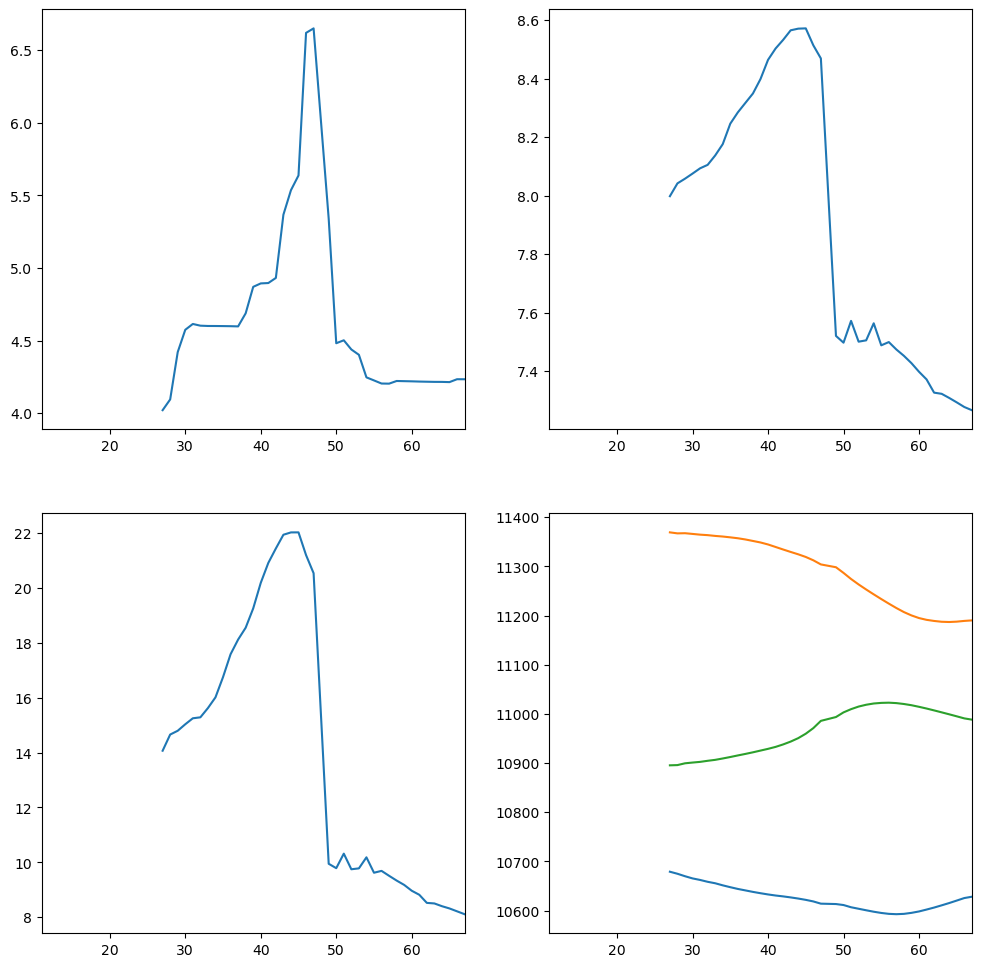

In [285]:
# Good behavior: 6706, 121, 6750, 4551, 9263, 2086, 6699, 3365, 6668, 4619, 1212, 4417, 8030, 5725, 178, 5618, 2008, 1979,
#                3372, 1099, 4411, 1977, 977, 7894, 1998, 5621, 4591, 1835, 9062, 4597, 1061, 3377, 4519, 5491, 9063, 9223,
#                214, 1157
# Questionable behavior: 4488^1, 2020^1, 6727^2, 1944^3, 6705^2
# ^1: insufficient halos
# ^2: skips too large (will need to edit this during filtering)
# ^3: halo switch, unsure of how to avoid

sim = 'z5m11a'
halo = '1944'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

with h5py.File(f'../data/ProgenitorTracks/temp_{sim}_{halo}_rockstar_progenitortracks.hdf5', 'r') as newfile:
    
    snaps = np.arange(11, 68)
    prog_ids = newfile['prog.id'][:][::-1]
    print(prog_ids)
    plot = prog_ids != -1
    
    mstell50 = newfile['prog.mstell50'][:][::-1]
    mvir = newfile['prog.mvir'][:][::-1]
    rvir = newfile['prog.rvir'][:][::-1]
    pos = newfile['prog.position'][:][::-1, :]
    
    ax1.plot(snaps[plot], mstell50[plot])
    ax1.set_xlim(11, 67)
    
    ax2.plot(snaps[plot], mvir[plot])
    ax2.set_xlim(11, 67)
    
    ax3.plot(snaps[plot], rvir[plot])
    ax3.set_xlim(11, 67)
    
    ax4.plot(snaps[plot], pos[plot, 0])
    ax4.plot(snaps[plot], pos[plot, 1])
    ax4.plot(snaps[plot], pos[plot, 2])
    ax4.set_xlim(11, 67)


# in utilities.simulation.Snapshot():
* reading:  projects/b1026/gjsun/high_redshift/z5m11a/snapshot_times.txt

* input redshift = 5.923078537:  using snapshot index = 53, redshift = 5.923


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_053.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 28855528 particles
    dark2     (id = 2): 3910682 particles
    gas       (id = 0): 28697333 particles
    star      (id = 4): 159980 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_053.hdf5

! cannot find MUSIC config file:  projects/b1026/gjsun/high_redshift/z5m11a/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle prope

* input redshift = 6.162790298:  using snapshot index = 50, redshift = 6.163


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_050.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 28855528 particles
    dark2     (id = 2): 3910682 particles
    gas       (id = 0): 28768152 particles
    star      (id = 4): 87800 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_050.hdf5

! cannot find MUSIC config file:  projects/b1026/gjsun/high_redshift/z5m11a/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties

  cannot read file containing hosts coordinates
  instead will assign hosts via iterative zoom on particle 


  cannot read file containing hosts coordinates
  instead will assign hosts via iterative zoom on particle mass

# in utilities.particle.get_center_positions():
* assigning position for 1 center/host, via iterative zoom-in on star particle mass
  host1 position = (10620.95, 11308.17, 10977.76) [kpc comoving]

# in utilities.particle.get_center_velocities_or_accelerations():
* assigning velocity for 1 center/host, weighting star particles by mass
  host1 velocity = (4.3, 4.7, -12.1) [km/s]


# in gizmo_analysis.gizmo_star.MassLoss():
* generating 2-D spline to compute stellar mass loss from age + metallicity
  number of age bins = 20
  number of metallicity bins = 25

# in utilities.simulation.Snapshot():
* reading:  projects/b1026/gjsun/high_redshift/z5m11a/snapshot_times.txt

  using snapshot index = 48, redshift = 6.333

* read 10285 halos from:  projects/b1026/gjsun/high_redshift/z5m11a/halo/rockstar_dm/catalog_hdf5/halo_048.hdf5

# in halo_analysis.halo_io.Particle():
* read 10285

5.725407 [10643.177 11297.074 10960.912]
6.1384053 [10629.662 11303.147 10975.5  ]
5.5680637 [10632.441 11299.735 10967.809]
5.487658 [10640.28  11303.059 10970.985]
6.74861 [10628.573 11313.279 10975.691]
5.769877 [10637.544 11303.706 10976.044]
5.5556455 [10642.75  11303.662 10978.016]
5.7296414 [10643.927 11311.309 10974.295]
5.834075 [10648.427 11297.897 10971.323]
6.807058 [10642.941 11313.074 10969.089]
5.817177 [10645.133 11318.104 10968.309]
5.869094 [10651.235 11309.132 10973.25 ]
6.1416855 [10594.604 11317.882 10974.824]
6.23135 [10599.016 11320.118 10974.31 ]
5.8273883 [10608.206 11324.956 10964.383]
6.156135 [10604.133 11308.206 10976.721]
6.702228 [10616.073 11316.367 10979.809]
5.6144323 [10623.941 11323.691 10966.118]
5.9744782 [10631.441 11330.56  10967.941]
6.911597 [10617.662 11317.927 10968.971]
10.077993 [10622.118 11308.721 10975.927]
6.322098 [10626.073 11314.118 10972.647]
5.8841205 [10633.485 11337.059 10978.162]
5.803166 [10614.088 11292.971 10980.677]
5.472670

5.806709 [10612.456 11309.147 10969.191]
5.5021257 [10615.868 11312.206 10965.545]
6.471141 [10622.544 11315.515 10965.75 ]
6.2178707 [10633.132 11321.221 10968.779]
5.494952 [10648.794 11314.427 10962.471]
5.6899357 [10648.735 11318.073 10969.882]
6.8095207 [10617.162 11278.485 10976.339]
5.813709 [10623.529 11283.75  10974.544]
5.725407 [10631.573 11297.118 10977.868]
5.5021257 [10643.015 11291.162 10976.721]
7.042524 [10619.162 11302.81  10974.941]
6.130102 [10621.985 11311.941 10980.103]
6.8448796 [10619.015 11316.294 10969.5  ]
7.3346314 [10624.633 11306.368 10980.015]
6.212344 [10648.146 11316.574 10981.854]
5.904326 [10644.5   11287.28  10973.427]
5.834075 [10651.765 11299.074 10976.559]
5.85034 [10646.544 11310.5   10970.882]
6.93005 [10645.824 11305.324 10970.353]
5.9598413 [10651.353 11301.853 10967.574]
5.5801196 [10652.662 11320.795 10974.015]
5.5021257 [10615.632 11316.162 10967.029]
6.05326 [10617.015 11315.221 10955.382]
6.0264316 [10617.427 11318.559 10954.485]
5.542880

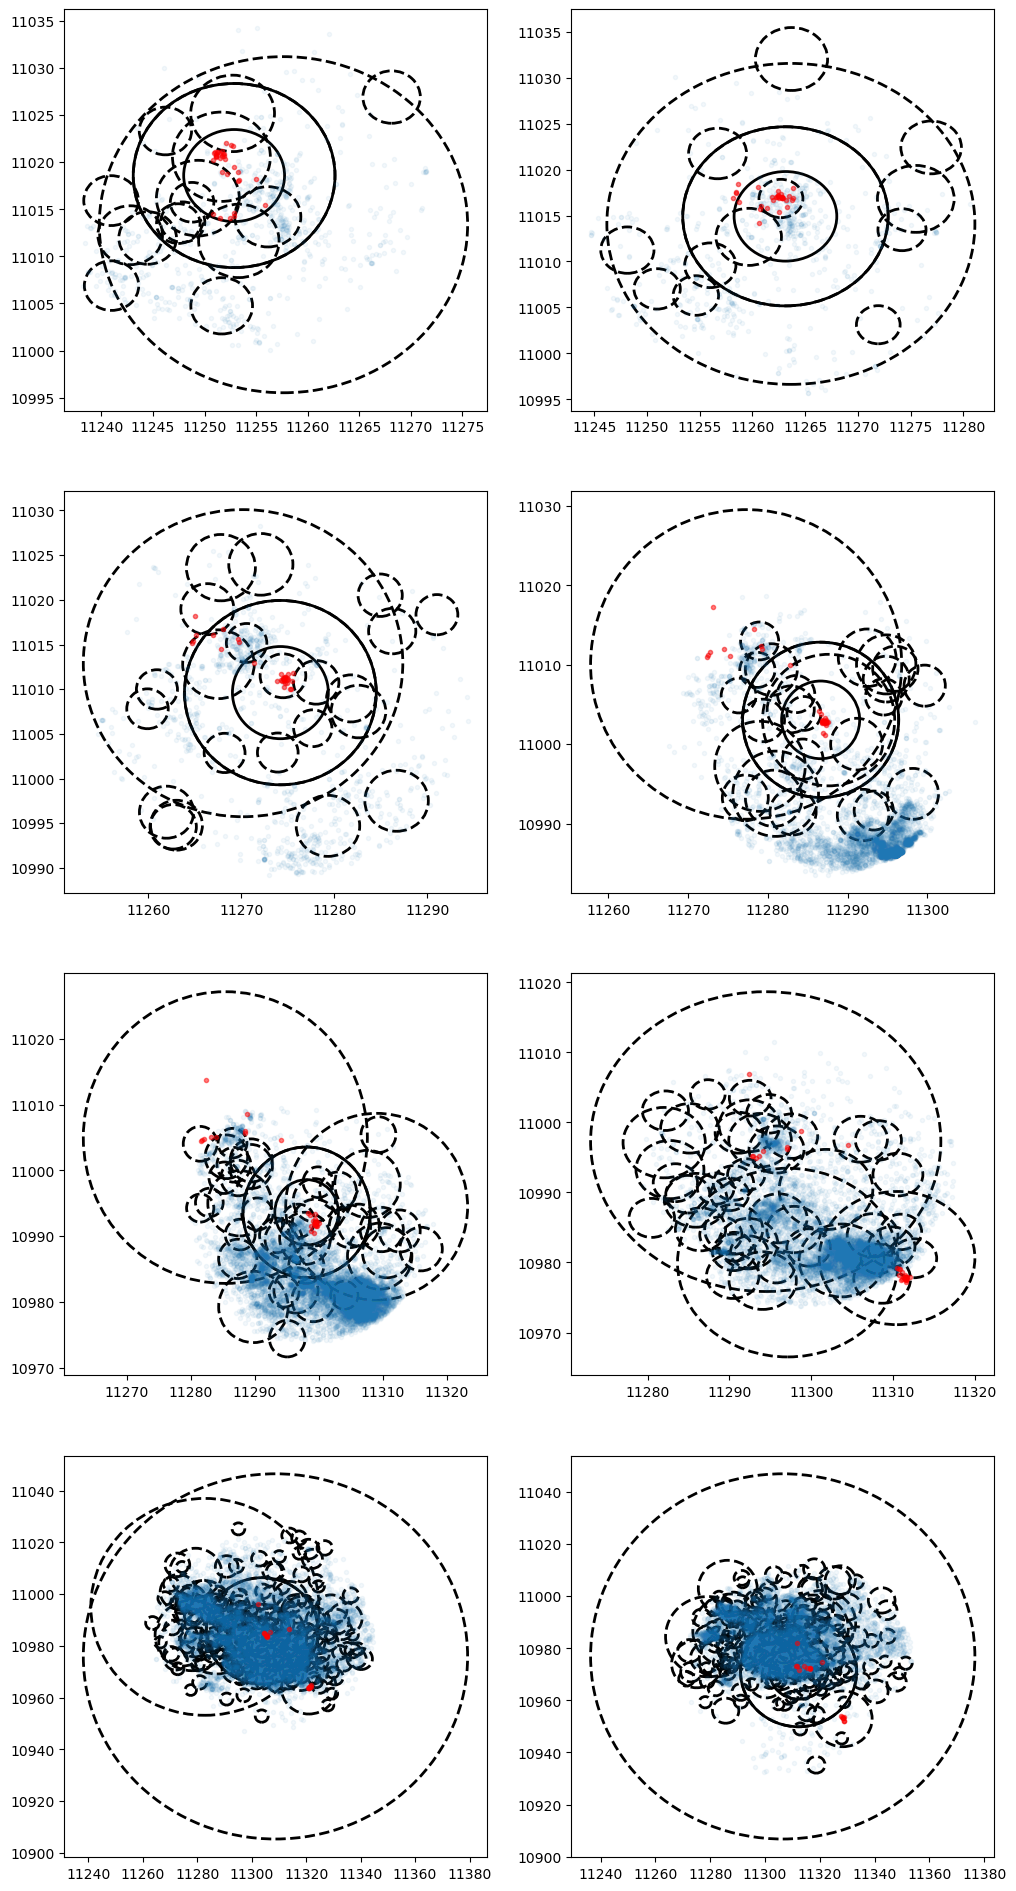

In [284]:
#fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 18))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 24))
snaptimes = np.loadtxt('/projects/b1026/gjsun/high_redshift/z5m11a/snapshot_times.txt')

halo = '1944'
startsnap = 53
#snaps = [startsnap - i for i in range(6)]
snaps = [startsnap - i for i in range(8)]
zsnaps = [snaptimes[snap, 2] for snap in snaps]
#axes = (ax1, ax2, ax3, ax4, ax5, ax6)
axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)

with h5py.File(f'../data/ProgenitorTracks/temp_z5m11a_{halo}_rockstar_progenitortracks.hdf5', 'r') as tempfile:
    start_idx = 67-startsnap
    end_idx = 68-snaps[-1]
    halos = tempfile['prog.id'][:][start_idx:end_idx]

for i, (ax, snap, z, halo) in enumerate(zip(axes, snaps, zsnaps, halos)):
    part = gizmo.io.Read.read_snapshots('star', 'redshift', z, '/projects/b1026/gjsun/high_redshift/z5m11a')
    starids, starpos, starmass = ht.unpackAndSortPartDict(part, starID_form='string')[:3]
    h = part.Cosmology['hubble']

    hal = ht.getData('z5m11a', snap, 'rockstar')
    haloids, halorad, halomvir, halopos = ht.unpackData(hal, 'z5m11a', snap, z, h, 'rockstar')
    
    axes_idx = np.array([1, 2])
    
    if halo != -1:
        idx = np.where(haloids == halo)[0][0]
        rad = halorad[idx]
        pos = halopos[idx]
        print(halo)
        print(rad)
        draw_unfilled_circle(ax, pos[axes_idx], rad)
        draw_unfilled_circle(ax, pos[axes_idx], rad/2)
        
        halo_distfilt = np.linalg.norm(halopos - pos, axis=1) < 2*rad
        halo_massfilt = np.log10(halomvir) >= 5.
        filt = halo_distfilt & halo_massfilt
        for (raddraw, massdraw, posdraw) in zip(halorad[filt], halomvir[filt], halopos[filt]):
            print(np.log10(massdraw), posdraw)
            draw_unfilled_circle(ax, posdraw[axes_idx], raddraw, linestyle='--')
        
    else:
        halo_distfilt = np.linalg.norm(halopos - pos, axis=1) < 2*rad
        halo_massfilt = np.log10(halomvir) >= 5.
        filt = halo_distfilt & halo_massfilt
        for (raddraw, massdraw, posdraw) in zip(halorad[filt], halomvir[filt], halopos[filt]):
            print(np.log10(massdraw), posdraw)
            draw_unfilled_circle(ax, posdraw[axes_idx], raddraw, linestyle='--')
    print(pos)
    
    draw_starparticle = np.linalg.norm(starpos - pos, axis=1) < 2*rad
    if i == 0:
        init_starparticles_idx = np.linalg.norm(starpos - pos, axis=1) < 0.5*rad
        init_starparticles = starids[init_starparticles_idx]
    else:
        init_starparticles_idx = np.isin(starids, init_starparticles)      
        
    ax.plot(starpos[draw_starparticle, 1], starpos[draw_starparticle, 2], marker='o', markersize=3, linestyle='None', alpha=0.05)
    ax.plot(starpos[init_starparticles_idx, 1], starpos[init_starparticles_idx, 2], color='red', marker='o', markersize=3, linestyle='None', alpha=0.5)

<KeysViewHDF5 ['prog.id', 'prog.mstell', 'prog.mvir', 'prog.position', 'prog.radius', 'time']>
[2009 4379 5477  952 5572  902 5434  865 3271 2188 2118 2103 2240 1002
 3716 2236 2306 2239 3847 1019 2498 2452 1069 1243 4094 1281 4133 4072
 1234 2599 1220 3992 2550 2994  261 3716 2474 1501 2462 5924 5955 5937
 6321   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1]
[2009 4379 1985  950 5563  893 5506  919  789 5791 5830 2212 7075 1075
 3773 2248 2336 2283 1232 2489 1250 1275   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1]
[ 6.81492996  6.78110838  7.3004775   7.19307041  6.04481745  5.90895844
  5.87559128  6.30249834  6.8464694   5.83969307  5.31261492  4.10752821
  4.35040474  3.95876074  3.99169636  4.12746096  4.23607302  4.79147196
  4.92811251  4.74470901  4.1113019   3.99996638 -1.         -1.
 -1.         -1.         -1.         -1

/tmp/ipykernel_628905/1197299093.py:26: RuntimeWarning: invalid value encountered in log10
  mvir_old = np.log10(oldfile['prog.mstell'][:])


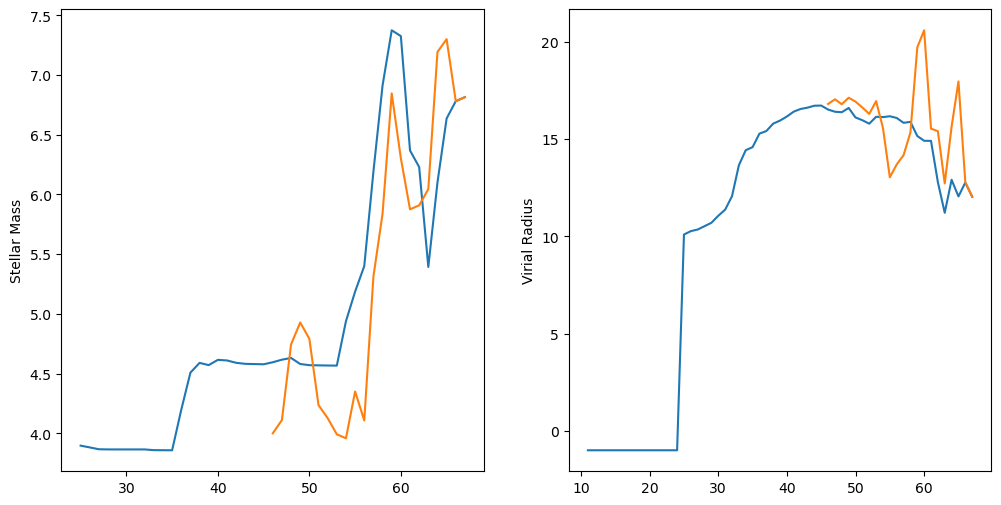

In [152]:
# Weird: 2002^1*, 2003^2, 2009^2, 5489^3
# Ambiguous: 5446
# Better: 2004, 3380, 1993, 5490, 5798, 7791, 8102
# ^1: Weird halo behavior, no good progenitor identified
# ^2: Required adjusting (lowering) fmatch fractions (0.1 to 0.03 for relaxation 1)
# ^3: Required adjusting (raising) mass difference filter
# ^*: Unsatisfactory result

sim = 'z5m11a'
halo = '2009'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

with h5py.File(f'../data/ProgenitorTracks/temp_{sim}_{halo}_rockstar_progenitortracks.hdf5', 'r') as newfile:
    with h5py.File(f'../../Thesis/data/ProgenitorTracks/{sim}_rockstar_progenitortracks.hdf5', 'r') as oldfile:
        oldfile = oldfile[halo]
    #with h5py.File(f'../../Thesis/data/ProgenitorTracks/temp_z5m11a_{halo}_rockstar_progenitortracks.hdf5', 'r') as oldfile:
        
        print(oldfile.keys())
        print(oldfile['prog.id'][:].astype(int))
        print(newfile['prog.id'][:].astype(int))
        #for elem in zip(oldfile['prog.id'][:].astype(int), newfile['prog.id'][:].astype(int)):
        #    print(elem)
            
        #print(newfile['prog.relaxation'][:])
        
        #mvir_old = np.log10(oldfile['prog.mvir'][:])
        mvir_old = np.log10(oldfile['prog.mstell'][:])
        #mvir_new = newfile['prog.mvir'][:]
        mvir_new = newfile['prog.mstell100'][:]
        print(mvir_new)
        #print(mvir_old)
        #print(mvir_new)
        ax1.plot(np.arange(len(mvir_old))[::-1]+11, mvir_old)
        ax1.plot(np.arange(len(mvir_new))[::-1][mvir_new != -1]+11, mvir_new[mvir_new != -1])
        ax1.set_ylabel('Stellar Mass')
        
        rvir_old = oldfile['prog.radius'][:]
        rvir_new = newfile['prog.rvir'][:]
        #print(rvir_new)
        ax2.plot(np.arange(len(rvir_old))[::-1]+11, rvir_old)
        ax2.plot(np.arange(len(rvir_new))[::-1][rvir_new != -1]+11, rvir_new[rvir_new != -1])
        ax2.set_ylabel('Virial Radius')

[(5489.0, 5489.0), (7875.0, 4375.0), (5451.0, 1981.0), (1786.0, 1878.0), (2001.0, 2012.0), (3191.0, 1901.0)]
***
[ 74.4334259  104.32622528 102.94993591 101.35747528  99.85263824
  99.25576782  98.17358398  96.98406982  95.69245148  93.64705658
  89.80752563  84.62188721  80.68383026  78.65457153  76.90567017
  75.2970047   73.52510834  72.22479248  71.56911469  70.96050262
  70.56602478  70.13387299  69.40708923  68.63817596  67.54569244
  65.76007843  64.54558563  62.41475296  59.00450897  54.93837357
  53.26194     51.69982147  50.62634277  49.20138168  46.94996262
  45.91478348  45.07667923  44.13814926  43.13827515  42.10310364
  41.16017151  40.03235245  38.40890121  32.54715729  29.20131683
  27.30135345  24.32788849  23.57938766  22.51622772  20.7087059
  19.25730896  17.52058792  16.38976479  15.91462612  15.330863
  14.98092079  14.53538799]
[(5489.0, 5489.0), (7875.0, 4375.0), (5451.0, 1981.0), (1786.0, 1878.0), (2001.0, 2012.0), (3191.0, 1901.0)]

# in utilities.simulation.

  species: ['star']

* reading particles from:
    projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_064.hdf5

! cannot find MUSIC config file:  projects/b1026/gjsun/high_redshift/z5m11a/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties

  cannot read file containing hosts coordinates
  instead will assign hosts via iterative zoom on particle mass

# in utilities.particle.get_center_positions():
* assigning position for 1 center/host, via iterative zoom-in on star particle mass
  host1 position = (10634.88, 11280.70, 10981.56) [kpc comoving]

# in utilities.particle.get_center_velocities_or_accelerations():
* assigning velocity for 1 center/host, weighting star particles by mass
  host1 velocity = (-1.4, 26.3, -3.4) [km/s]


# in gizmo_analysis.gizmo_star.MassLoss():
* generating 2-D spline to compute stellar mass loss from 

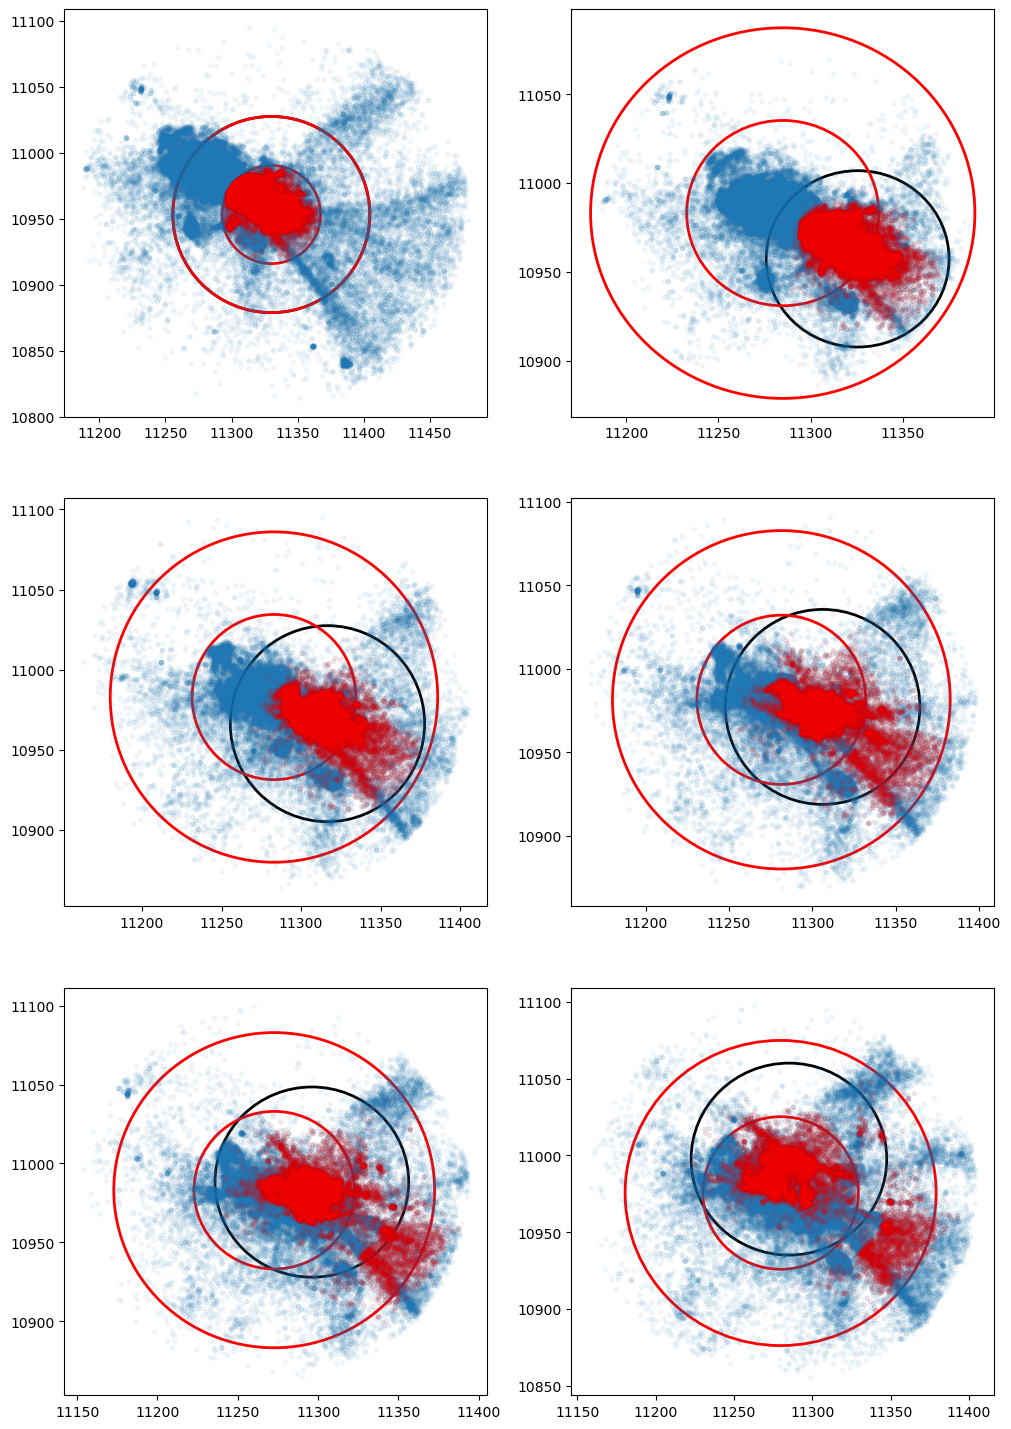

In [144]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 18))

snaptimes = np.loadtxt('/projects/b1026/gjsun/high_redshift/z5m11a/snapshot_times.txt')

halo = '5489'
startsnap = 67
snaps = [startsnap - i for i in range(6)]
zsnaps = [snaptimes[snap, 2] for snap in snaps]
axes = (ax1, ax2, ax3, ax4, ax5, ax6)

with h5py.File('../../Thesis/data/ProgenitorTracks/z5m11a_rockstar_progenitortracks.hdf5', 'r') as origfile:
    with h5py.File(f'../data/ProgenitorTracks/temp_z5m11a_{halo}_rockstar_progenitortracks.hdf5', 'r') as v2file:
        start_idx = 67-startsnap
        end_idx = 68-snaps[-1]
        if halo != '1961':   # 3380
            halo_pairs = list(zip(origfile[halo]['prog.id'][:][start_idx:end_idx], v2file['prog.id'][:][start_idx:end_idx]))
        else:
            halo_pairs = list(zip(-np.ones(6), v2file['prog.id'][:][start_idx:end_idx]))
        print(halo_pairs)
        
        print('***')
        print(v2file['prog.rvir'][:])
    
    #print(origfile[halo]['prog.id'][:])
    #print(origfile[halo]['prog.radius'][:])
    #print(np.log10(origfile[halo]['prog.mvir'][:]))
        
print(halo_pairs)

for i, (ax, snap, z, halo_pair) in enumerate(zip(axes, snaps, zsnaps, halo_pairs)):
    
    part = gizmo.io.Read.read_snapshots('star', 'redshift', z, '/projects/b1026/gjsun/high_redshift/z5m11a')
    starids, starpos, starmass = ht.unpackAndSortPartDict(part, starID_form='string')[:3]
    h = part.Cosmology['hubble']
    
    hal = ht.getData('z5m11a', snap, 'rockstar')
    haloids, halorad, halomvir, halopos = ht.unpackData(hal, 'z5m11a', snap, z, h, 'rockstar')
    
    idx_orig = np.where(haloids == halo_pair[0])[0][0] if halo_pair[0] != -1 else None
    idx_new = np.where(haloids == halo_pair[1])[0][0] if halo_pair[1] != -1 else None
    axes_idx = np.array([1, 2])
    
    if idx_orig is not None:
        rad_orig = halorad[idx_orig]
        pos_orig = halopos[idx_orig]
        draw_unfilled_circle(ax, pos_orig[axes_idx], rad_orig)
        if idx_new is not None:
            rad_new = halorad[idx_new]
            pos_new = halopos[idx_new]
            draw_unfilled_circle(ax, pos_new[axes_idx], rad_new, color='red')
            draw_unfilled_circle(ax, pos_new[axes_idx], rad_new/2, color='red')
        else:
            pass
    else:
        if idx_new is not None:
            rad_new = halorad[idx_new]
            pos_new = halopos[idx_new]
            draw_unfilled_circle(ax, pos_new[axes_idx], rad_new, color='red')
            draw_unfilled_circle(ax, pos_new[axes_idx], rad_new/2, color='red')
        else:
            pass
        
    
    draw_starparticle = np.linalg.norm(starpos - pos_new, axis=1) < 2*rad_orig
    if i == 0:
        init_starparticles_idx = np.linalg.norm(starpos - pos_new, axis=1) < 0.5*rad_orig
        init_starparticles = starids[init_starparticles_idx]
    else:
        init_starparticles_idx = np.isin(starids, init_starparticles)
    #in_new = np.linalg.norm(starpos - pos_new, axis=1) < 0.5*rad_new
    ax.plot(starpos[draw_starparticle, 1], starpos[draw_starparticle, 2], marker='o', markersize=3, linestyle='None', alpha=0.05)
    ax.plot(starpos[init_starparticles_idx, 1], starpos[init_starparticles_idx, 2], color='red', marker='o', markersize=3, linestyle='None', alpha=0.05)
    #ax.plot(starpos[in_new, 0], starpos[in_new, 1], marker='o', markersize=3, color='red', linestyle='None', alpha=0.2)
    
    #in_mainhalo = np.linalg.norm(pos_orig - halopos, axis=1) < 1.5*rad_orig
    #for (pos, rad) in zip(halopos[in_mainhalo], halorad[in_mainhalo]):
    #    draw_unfilled_circle(ax, pos, rad, color='black', linewidth=0.5)

In [20]:
xarr = np.arange(5)+5
xarr[np.array([2, 1, 0])]

array([7, 6, 5])


# in utilities.simulation.Snapshot():
* reading:  projects/b1026/gjsun/high_redshift/z5m11a/snapshot_times.txt

* input redshift = 5.0:  using snapshot index = 67, redshift = 5.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_067.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 28855528 particles
    dark2     (id = 2): 3910682 particles
    gas       (id = 0): 28635825 particles
    star      (id = 4): 222210 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    projects/b1026/gjsun/high_redshift/z5m11a/output/snapshot_067.hdf5

! cannot find MUSIC config file:  projects/b1026/gjsun/high_redshift/z5m11a/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties

 

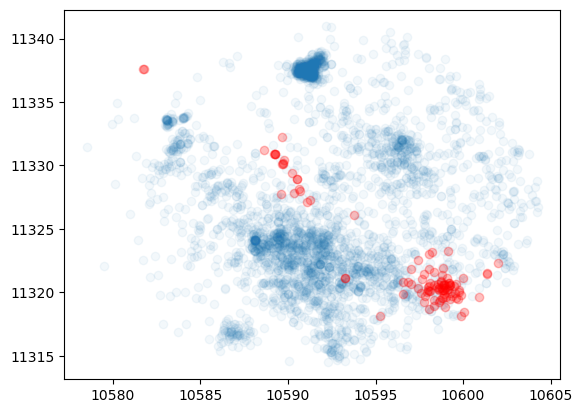

In [103]:
with h5py.File('../data/HaloStarCatalogs/halostarcatalog_z5m11a.hdf5', 'r') as catalog:
    decoder = np.vectorize(lambda x: x.decode('utf-8'))
    starids65 = decoder(catalog['65']['5472']['star.ids'][:])
    starids67 = decoder(catalog['67']['5446']['star.ids'][:])
    
    part = gizmo.io.Read.read_snapshots('star', 'redshift', 5., '/projects/b1026/gjsun/high_redshift/z5m11a')
    starids, starpos, starmass = ht.unpackAndSortPartDict(part, starID_form='string')[:3]
    inhalo = np.isin(starids, starids67)
    starpos67 = starpos[inhalo]
    
    in65 = np.isin(starids67, starids65)
    
    plt.scatter(starpos67[~in65, 0], starpos67[~in65, 1], alpha=0.05)
    plt.scatter(starpos67[in65, 0], starpos67[in65, 1], color='red', alpha=0.25)

In [149]:
with h5py.File('../data/HaloStarCatalogs/halostarcatalog_z5m11a.hdf5', 'r') as catalog:
    print(np.log10(catalog['67']['5489']['halo.mvir'][()]))
    print(np.log10(catalog['66']['7875']['halo.mvir'][()]))

10.151262
9.621116
